In [1]:
import diffusers
import torch
import random
from tqdm import tqdm

pipe = diffusers.StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda", torch.float16)

/home/ubuntu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-08 22:14:03.023465: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 22:14:03.824770: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/ubuntu/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading p

In [15]:
# lets identify a latent direction by taking differences between opposites

mediums = [
    "painting",
    "drawing",
    "photograph",
    "HD photo",
    "illustration",
    "portrait",
    "sketch",
    "3d render",
    "digital painting",
    "concept art",
    "screenshot",
]

subjects = [
    "dog",
    "cat",
    "car",
    "building",
    "house",
    "tree",
    "flower",
    "mountain",
    "lake",
    "person",
    "man",
    "woman",
    "toy",
    "horse",
    "bird",
    "soup",
    "chicken"
]

# target_word = "happy"
# opposite = "sad"

target_word = "old"
opposite = "young"

num = 300

with torch.no_grad():
    positives = []
    negatives = []
    for i in tqdm(range(num)):
        medium = random.choice(mediums)
        subject = random.choice(subjects)
        pos_prompt = f"a {medium} of a {target_word} {subject}"
        neg_prompt = f"a {medium} of a {opposite} {subject}"
        pos_toks = pipe.tokenizer(pos_prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
        neg_toks = pipe.tokenizer(neg_prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
        pos = pipe.text_encoder(pos_toks).pooler_output
        neg = pipe.text_encoder(neg_toks).pooler_output
        positives.append(pos)
        negatives.append(neg)

100%|██████████| 200/200 [00:03<00:00, 64.20it/s]


In [16]:
positives = torch.cat(positives, dim=0)
negatives = torch.cat(negatives, dim=0)

diffs = positives - negatives

avg_diff = diffs.mean(0, keepdim=True)

In [17]:
prompt = "a portrait of a cat"
toks = pipe.tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
prompt_embeds = pipe.text_encoder(toks).last_hidden_state


# if doing full sequence, [-0.3,0.3] work well
# if pooler token only [-4,4] work well
scale = 5
seed = 6
only_pooler = True

if only_pooler:
    prompt_embeds[:,toks.argmax()] = prompt_embeds[:,toks.argmax()] + avg_diff * scale
else:
    prompt_embeds = prompt_embeds + avg_diff.unsqueeze(0) * scale

torch.manual_seed(seed)
image = pipe(prompt_embeds=prompt_embeds, height=640, width=640).images

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.92it/s]


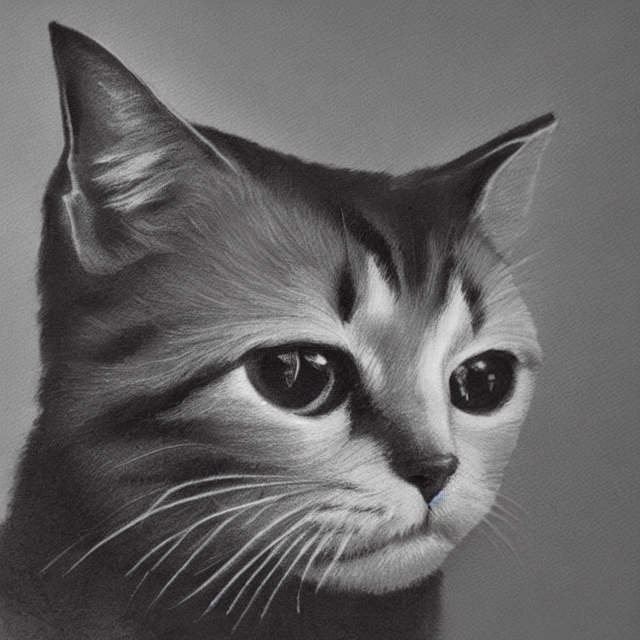

In [18]:
image[0]

In [32]:
# we can also try doing this in CLIPs input space/embedding table
# although this might be trickier if your two phrases are a different number of tokens
pos_phrase = "old"
neg_phrase = "young"

pos_toks = pipe.tokenizer(pos_phrase, return_tensors="pt", padding="longest", truncation=True, add_special_tokens=False).input_ids.cuda()
neg_toks = pipe.tokenizer(neg_phrase, return_tensors="pt", padding="longest", truncation=True, add_special_tokens=False).input_ids.cuda()

with torch.no_grad():
    pos_emb = pipe.text_encoder.text_model.embeddings(pos_toks)
    neg_emb = pipe.text_encoder.text_model.embeddings(neg_toks)
    diff = (pos_emb - neg_emb).squeeze(0)

In [68]:
from transformers.modeling_attn_mask_utils import _create_4d_causal_attention_mask

# this one doesnt seem to work as well
# -0.01, 0.01 if only_pooler
# -10, 10 if full sequence

prompt = "a portrait of a man"
scale = -0.01
scale = 10
seed = 11
only_pooler = True

toks = pipe.tokenizer(prompt, return_tensors="pt", padding="max_length", truncation=True, max_length=77).input_ids.cuda()
embedded = pipe.text_encoder.text_model.embeddings(toks)

if only_pooler:
    embedded[:,toks.argmax()] = embedded[:,toks.argmax()] + diff * scale
else:
    embedded = embedded + avg_diff.unsqueeze(0) * scale

causal_attention_mask = _create_4d_causal_attention_mask(
    toks.shape, embedded.dtype, device=embedded.device
)

encoder_outputs = pipe.text_encoder.text_model.encoder(
            inputs_embeds=embedded,
            attention_mask=None,
            causal_attention_mask=causal_attention_mask,
            output_attentions=False,
            output_hidden_states=False,
            return_dict=False,
        )

last_hidden_state = encoder_outputs[0]
last_hidden_state = pipe.text_encoder.text_model.final_layer_norm(last_hidden_state)

torch.manual_seed(seed)
image = pipe(prompt_embeds=last_hidden_state, height=640, width=640).images

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 17.27it/s]


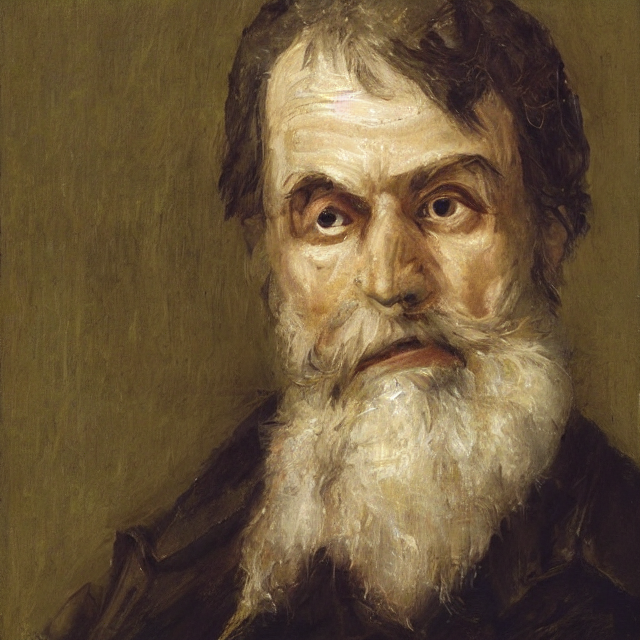

: 

In [69]:
image[0]

In [ ]:
# this method here is like a better version of the above, 
# by using gradient descent we can still work in input space but project back onto manifold
# https://github.com/ethansmith2000/SGDImagePrompt